# BIA 6304 Text Mining, Fall 2017
## Assignment 3
### Stuent:  Leonardo Ji
### 9/29/2017

#### T1.  Read in or create a data frame with at least one column of text to be analyzed.  This could be the text you used previously or new text. Choose a prediction you would like to make with these data and create the appropriate feature space. Identify the labels you will be trying to predict and proceed to create a train-test split. Using default model parameters, fit 3 classifiers (decision tree, naïve bayes, logistic regression, or knn) to your dataset and subsequently generate predictions (just like we did in class). Feel free to set a random state variable where appropriate to facilitate replication.  Assess the performance of the models using any of the measures (confusion matrices, precision, recall, f1-score, and accuracy).

![SNAP](https://snap.stanford.edu/images/snap_logo.png "Stanford Network Analysis Project")
I want to use a Amazon review data from [SNAP](https://snap.stanford.edu/data/web-Amazon.html)

In [1]:
from __future__ import division
from bs4 import BeautifulSoup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import gzip
import math
import numpy as np
import pandas as pd
import requests
import re


pd.set_option('display.max_colwidth', 150) #important for getting all the text

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

amazonReview = getDF('reviews_Musical_Instruments_5.json.gz')
print(len(amazonReview))
amazonReview.head()

10261


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is ...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better th...",5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with...",5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded w...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


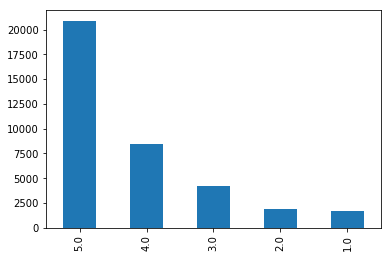

In [14]:
# What does our target variable look like?
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# get a feel for the distribution
amazonReview['overall'].value_counts().plot(kind='bar')
#badReview = amazonReview[(amazonReview['overall'] == 1)]
#goodReview = amazonReview[(amazonReview['overall'] == 5)]

In [31]:
# quick peak at basic feature space
dm = CountVectorizer(binary=False, stop_words = 'english') 
cv_dm = dm.fit_transform(amazonReview['reviewText'])
print(cv_dm.shape)

(10261, 20251)


In [32]:
names = dm.get_feature_names()
print(type(names), len(names))

<class 'list'> 20251


In [121]:
count = np.sum(cv_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

count_df.sort_values(['count'], ascending = False).head(20)

<class 'list'> 125


,count
guitar,5611
one,4558
great,4121
like,3981
good,3811
use,3788
sound,3609
strings,3420
well,3235
get,2683


In [34]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
print(type(X), X[0:10])


y = amazonReview['overall'].values #this is an array of labels
print(type(y), y[0:10])

<class 'numpy.ndarray'> [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [2 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
<class 'numpy.ndarray'> [ 5.  5.  5.  5.  5.  5.  5.  3.  5.  5.]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7182, 20251)
(3079, 20251)
(7182,)
(3079,)


##### Decision Tree

In [36]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.575511529717
accuracy: 0.575511529717
             precision    recall  f1-score   support

        1.0       0.23      0.14      0.17        72
        2.0       0.00      0.00      0.00        67
        3.0       0.13      0.11      0.12       229
        4.0       0.25      0.21      0.23       646
        5.0       0.71      0.78      0.74      2065

avg / total       0.54      0.58      0.56      3079



##### Naive Bayes

In [37]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.666774926924
accuracy: 0.666774926924
             precision    recall  f1-score   support

        1.0       0.50      0.03      0.05        72
        2.0       0.00      0.00      0.00        67
        3.0       0.21      0.01      0.02       229
        4.0       0.35      0.13      0.19       646
        5.0       0.70      0.95      0.80      2065

avg / total       0.57      0.67      0.58      3079



##### Logistic Regression

In [38]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.650860669048
accuracy: 0.650860669048
             precision    recall  f1-score   support

        1.0       0.58      0.10      0.17        72
        2.0       0.18      0.06      0.09        67
        3.0       0.28      0.13      0.18       229
        4.0       0.34      0.25      0.28       646
        5.0       0.73      0.87      0.80      2065

avg / total       0.60      0.65      0.61      3079



##### KNN

In [39]:
# loading library
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 3)
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)


# make predictions
knn1_expected = y_test
knn1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn1_expected, knn1_predicted)))
print(metrics.classification_report(knn1_expected, knn1_predicted))

0.644365053589
accuracy: 0.644365053589
             precision    recall  f1-score   support

        1.0       0.05      0.01      0.02        72
        2.0       0.04      0.01      0.02        67
        3.0       0.10      0.03      0.04       229
        4.0       0.24      0.04      0.06       646
        5.0       0.68      0.95      0.79      2065

avg / total       0.51      0.64      0.55      3079



##### Q1. Write a short description of the results of these “baseline” models. Make sure your answer is no longer than four paragraphs, and should at minimum answer these questions:
*	What decisions did you make when creating your feature space? Why?  
*	How do these classifiers address your question?
*	How did your models perform? Are you happy with the results?  Why or why not?
Audience: general – management or non-technical staff. NOTE: this is a GENERAL AUDIENCE RESPONSE - be VERY careful with how you mention/describe/discuss the various models.  Detailed descriptions of the classifiers is not required but any discussion of them must be NON TECHNICAL (but not fluffy).   


I used 10,261 Amazon music instrument review dataset for this question.  I want to know whether the review text can predict the overall rating of the products.  I used four models. The common stop words like a, an, the... are removed. All four models predict products’ overall rating based on data generated from counting single word term in the reviews.  
Four models produced accuracies around 60%.  The accuracies are lower than I expected.
All four models are better at predict overall rating of 1/1 or 5/5.  The middle overall rating are harder to predict because the words people use for great product and poor products are very unique. The user usually use positive words to describe product rated 5/5, and negative words to describe products rated 1/5. The average rating review likely do not stand out like those rated 1/1 or 5/5.  

The first model has overall accuracy of 57.5%, the second model has overall accuracy of 66.7%, the third model has overall accuracy of 65.1%, and the fourth model has overall accuracy of 64.4%.  The second and third models are much better than the other two models because they are better at predicting both very good rating (5/5) and very bad rating (1/1).  In the following section I will try to improve these base models.  I will focus on improve very bad rating where user ranked the product 1/1.

#### T2. Using a variety of parameter settings (for classifiers or vectorizers), try to improve on the performance of the baseline models.  At least 6 separate predictions should be run and the results reported in a table.  You can use any combination of parameters and classifiers; you do not need to use all classifiers. Make sure at least one example uses a preprocessing option (stemming, lemmatization, custom dictionary, custom stopwords, etc.)

In [3]:
# create a custom stopwords list - I choose to start with the nltk list
nltk_stopwords = stopwords.words("english")
print(len(nltk_stopwords))
new_nltk_stopwords = set(nltk_stopwords)
new_nltk_stopwords.update(set(['first', 'one', 'two', 'last', 'another', 'could', 'would', 'need']))
print(len(new_nltk_stopwords))

153
161


In [4]:
skl_stopwords = text.ENGLISH_STOP_WORDS
new_skl_stopwords = set(skl_stopwords)
print(len(new_skl_stopwords))
new_skl_stopwords.update(set(['need']))
print(len(new_skl_stopwords))

318
319


In [5]:
# Preprocessing to replace words
import re
my_dict = {'guitars':'guitar','picks':'pick', 'strings':'string', 'bought':'buy',
             'years': 'year', 'works':'work', 'schools':'school', 'using':'use',
            'sounds':'sound', 'makes':'make', 'made':'make', 'pedels':'pedel', 'playing':'play', 'tried':'try'}


def multiple_replace(dict, text): 

  """ Replace in 'text' all occurences of any key in the given
  dictionary by its corresponding value.  Returns the new tring.""" 
  text = str(text).lower()

  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

amazonReview['cleantext'] = amazonReview.reviewText.apply(lambda x: multiple_replace(my_dict, x))

In [6]:
ps = PorterStemmer() #define method (http://www.nltk.org/api/nltk.stem.html#nltk.stem.porter.PorterStemmer)
amazonReview['StemReviewText'] = [ps.stem(word) for word in amazonReview['reviewText']] 

##### Use count vectorizer 1: lowercase=True, stop_words=new_skl_stopwords,binary=False,max_df=0.95, min_df=0.05,ngram_range = (1,2)

In [491]:
cv1 = CountVectorizer(lowercase=True, 
                     stop_words=new_skl_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.05,
                     ngram_range = (1,2)) 

In [492]:
cv_dm = cv1.fit_transform(amazonReview['cleantext'])
print(cv_dm.shape)

names = cv1.get_feature_names()
print(type(names), len(names))

(10261, 88)
<class 'list'> 88


In [493]:
count = np.sum(cv_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

count_df.sort_values(['count'], ascending = False).head(20)

<class 'list'> 88


,count
guitar,6846
use,5221
string,4721
sound,4704
great,4121
like,3981
good,3811
just,3757
work,3128
make,2875


In [494]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X), X[0:10])


y = amazonReview['overall'].values #this is an array of labels
#print(type(y), y[0:10])

In [495]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7182, 88)
(3079, 88)
(7182,)
(3079,)


In [496]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.526144852225
accuracy: 0.526144852225
             precision    recall  f1-score   support

        1.0       0.04      0.04      0.04        72
        2.0       0.03      0.03      0.03        67
        3.0       0.12      0.12      0.12       229
        4.0       0.24      0.27      0.26       646
        5.0       0.71      0.68      0.70      2065

avg / total       0.54      0.53      0.53      3079



In [497]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.653134134459
accuracy: 0.653134134459
             precision    recall  f1-score   support

        1.0       0.26      0.11      0.16        72
        2.0       0.05      0.03      0.04        67
        3.0       0.15      0.04      0.06       229
        4.0       0.37      0.12      0.19       646
        5.0       0.70      0.93      0.80      2065

avg / total       0.57      0.65      0.58      3079



In [498]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.669697953881
accuracy: 0.669697953881
             precision    recall  f1-score   support

        1.0       0.75      0.04      0.08        72
        2.0       0.20      0.01      0.03        67
        3.0       0.12      0.01      0.02       229
        4.0       0.40      0.06      0.10       646
        5.0       0.68      0.98      0.80      2065

avg / total       0.57      0.67      0.56      3079



##### Use count vectorizer 2: lowercase=True, stop_words=new_skl_stopwords,binary=False,max_df=0.95, min_df=0.05,ngram_range = (1,2)

In [499]:
cv2 = CountVectorizer(lowercase=True, 
                     stop_words=new_skl_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.05,
                     ngram_range = (1,2)) 

In [500]:
cv2_dm = cv2.fit_transform(amazonReview['StemReviewText'])

# print matrix shape(s)
print(cv2_dm.shape)
names = cv2.get_feature_names()
print(type(names), len(names))

(10261, 98)
<class 'list'> 98


In [501]:
count = np.sum(cv2_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

count_df.sort_values(['count'], ascending = False).head(20)

<class 'list'> 98


,count
guitar,5617
great,4121
like,3981
good,3811
use,3783
just,3757
sound,3610
strings,3408
pedal,2575
really,2243


In [502]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = cv2_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X), X[0:10])

y = amazonReview['overall'].values #this is an array of labels
#print(type(y), y[0:10])

In [503]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7182, 98)
(3079, 98)
(7182,)
(3079,)


In [504]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.53329002923
accuracy: 0.53329002923
             precision    recall  f1-score   support

        1.0       0.04      0.04      0.04        72
        2.0       0.01      0.01      0.01        67
        3.0       0.10      0.12      0.11       229
        4.0       0.25      0.25      0.25       646
        5.0       0.72      0.70      0.71      2065

avg / total       0.54      0.53      0.54      3079



In [505]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.646963299773
accuracy: 0.646963299773
             precision    recall  f1-score   support

        1.0       0.19      0.10      0.13        72
        2.0       0.03      0.01      0.02        67
        3.0       0.11      0.03      0.05       229
        4.0       0.35      0.12      0.18       646
        5.0       0.70      0.92      0.79      2065

avg / total       0.56      0.65      0.58      3079



In [506]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.672620980838
accuracy: 0.672620980838
             precision    recall  f1-score   support

        1.0       0.60      0.04      0.08        72
        2.0       0.40      0.03      0.06        67
        3.0       0.17      0.01      0.02       229
        4.0       0.44      0.07      0.11       646
        5.0       0.68      0.98      0.80      2065

avg / total       0.59      0.67      0.57      3079



##### Use tfidf vectorizer: lowercase = True, stop_words= new_nltk_stopwords, max_df=0.95, min_df=0.05, ngram_range = (1,2)

In [402]:
tfidf1 = TfidfVectorizer(lowercase = True, 
                        stop_words= new_nltk_stopwords, 
                        max_df=0.95, 
                        min_df=0.05,
                        ngram_range = (1,2))

In [403]:
tfidf_dm = tfidf1.fit_transform(amazonReview['cleantext'])

# print matrix shape(s)
print(tfidf_dm.shape)
names = tfidf1.get_feature_names()
print(type(names), len(names))

(10261, 108)
<class 'list'> 108


In [404]:
count = np.sum(tfidf_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

count_df.sort_values(['count'], ascending = False).head(20)

<class 'list'> 108


,count
guitar,921.348728
string,757.355210
use,741.822023
great,727.593655
good,661.405896
sound,658.414304
work,601.677799
like,588.873463
well,560.198404
buy,504.929865


In [406]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = tfidf_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X), X[0:10])

y = amazonReview['overall'].values #this is an array of labels
#print(type(y), y[0:10])

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7182, 108)
(3079, 108)
(7182,)
(3079,)


In [408]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.539460863917
accuracy: 0.539460863917
             precision    recall  f1-score   support

        1.0       0.09      0.07      0.08        72
        2.0       0.03      0.03      0.03        67
        3.0       0.09      0.09      0.09       229
        4.0       0.25      0.23      0.24       646
        5.0       0.70      0.72      0.71      2065

avg / total       0.53      0.54      0.53      3079



In [409]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.6706722962
accuracy: 0.6706722962
             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00        72
        2.0       0.00      0.00      0.00        67
        3.0       0.00      0.00      0.00       229
        4.0       0.00      0.00      0.00       646
        5.0       0.67      1.00      0.80      2065

avg / total       0.45      0.67      0.54      3079



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [410]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.673270542384
accuracy: 0.673270542384
             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00        72
        2.0       0.00      0.00      0.00        67
        3.0       0.50      0.00      0.01       229
        4.0       0.40      0.09      0.14       646
        5.0       0.69      0.98      0.81      2065

avg / total       0.58      0.67      0.57      3079



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### Use PCA to reduce feature spaces on count vectorizer 3 lowercase=True, stop_words=new_skl_stopwords,binary=False,max_df=0.95,min_df=0.001,ngram_range = (1,2)

In [429]:
cv3 = CountVectorizer(lowercase=True, 
                     stop_words=new_skl_stopwords,
                     binary=False,
                     max_df=0.95,
                     min_df=0.001, #prevent memory error have to set a min_df
                     ngram_range = (1,2)) 

In [430]:
cv3_dm = cv3.fit_transform(amazonReview['cleantext'])

# print matrix shape(s)
print(cv3_dm.shape)
names = cv3.get_feature_names()
print(type(names), len(names))

(10261, 5883)
<class 'list'> 5883


In [438]:
# Is this what we need to get better predictions for our news articles?
# First question:  How many components?

# Our original feature space was pretty big
print(cv3_dm.shape)

from sklearn.decomposition import PCA, RandomizedPCA

# we want something that is smaller than 5883 
# let's start with 800 - that's about how big the second round space was
# maybe we've kept more info for the same number of features


pca = PCA(n_components=800)
X_pca = pca.fit_transform(cv3_dm.toarray())

print( 'PCA Total Variance Explained: ' + str(sum(pca.explained_variance_ratio_)))

(10261, 5883)
PCA Total Variance Explained: 0.828651554237


In [439]:
#set up our test and training vectors with the PCA'd vector space
X = X_pca  #remember this is the output from the vectorizer and we are turning it into an array
y = amazonReview['overall'].values #this is an array of labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed


# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.506658005846
accuracy: 0.506658005846
             precision    recall  f1-score   support

        1.0       0.03      0.03      0.03        72
        2.0       0.04      0.06      0.05        67
        3.0       0.08      0.10      0.08       229
        4.0       0.26      0.26      0.26       646
        5.0       0.69      0.66      0.67      2065

avg / total       0.52      0.51      0.52      3079



In [440]:
# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.666450146151
accuracy: 0.666450146151
             precision    recall  f1-score   support

        1.0       0.39      0.10      0.16        72
        2.0       0.18      0.09      0.12        67
        3.0       0.25      0.14      0.18       229
        4.0       0.39      0.22      0.28       646
        5.0       0.73      0.90      0.81      2065

avg / total       0.61      0.67      0.62      3079



##### Use TfidfVectorizer 2: lowercase = True, binary=False, stop_words = new_nltk_stopwords,max_df=0.95, min_df=0.001, ngram_range = (1,2)

In [7]:
tfidf2 = TfidfVectorizer(lowercase = True, 
                          binary=False, 
                          stop_words = new_nltk_stopwords,
                          max_df=0.95,
                          min_df=0.001,  #prevent memory error have to set a min_df
                          use_idf = False,
                          ngram_range = (1,2)) 

In [8]:
tfidf2_dm = tfidf2.fit_transform(amazonReview['cleantext'])

# print matrix shape(s)
print(tfidf2_dm.shape)
names = tfidf2.get_feature_names()
print(type(names), len(names))

(10261, 6238)
<class 'list'> 6238


In [9]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = tfidf2_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X), X[0:10])

y = amazonReview['overall'].values #this is an array of labels
#print(type(y), y[0:10])

In [461]:
# use cosine similarity 
from sklearn.metrics.pairwise import cosine_similarity
X = cosine_similarity(X)

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7182, 10261)
(3079, 10261)
(7182,)
(3079,)


In [463]:
# loading library
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 3)
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)


# make predictions
knn1_expected = y_test
knn1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn1_expected, knn1_predicted)))
print(metrics.classification_report(knn1_expected, knn1_predicted))

0.539460863917
accuracy: 0.539460863917
             precision    recall  f1-score   support

        1.0       0.02      0.03      0.02        72
        2.0       0.06      0.13      0.09        67
        3.0       0.11      0.12      0.11       229
        4.0       0.26      0.14      0.18       646
        5.0       0.69      0.74      0.71      2065

avg / total       0.53      0.54      0.53      3079



In [10]:
X = tfidf2_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7182, 6238)
(3079, 6238)
(7182,)
(3079,)


In [465]:
# instantiate learning model (k = 3)
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)


# make predictions
knn1_expected = y_test
knn1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn1_expected, knn1_predicted)))
print(metrics.classification_report(knn1_expected, knn1_predicted))

0.666450146151
accuracy: 0.666450146151
             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00        72
        2.0       0.17      0.01      0.03        67
        3.0       0.12      0.01      0.02       229
        4.0       0.25      0.00      0.00       646
        5.0       0.67      0.99      0.80      2065

avg / total       0.52      0.67      0.54      3079



In [466]:
from sklearn.model_selection import cross_val_score
# creating odd list of K for KNN
myList = list(range(1,35))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

#takes some time, get a soda...
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 29


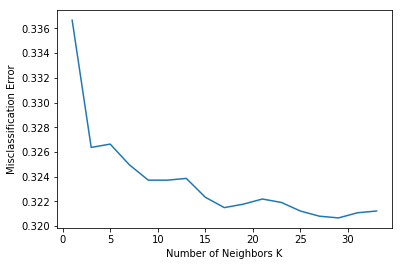

In [467]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [13]:
# Try Pick 29 neighbors.

# instantiate learning model 
model = KNeighborsClassifier(n_neighbors=29)
model.fit(X_train, y_train)


# make predictions
knn2_expected = y_test
knn2_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn2_expected, knn2_predicted)))
print(metrics.classification_report(knn2_expected, knn2_predicted))

0.670997076973
accuracy: 0.670997076973
             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00        72
        2.0       0.00      0.00      0.00        67
        3.0       0.00      0.00      0.00       229
        4.0       0.33      0.00      0.01       646
        5.0       0.67      1.00      0.80      2065

avg / total       0.52      0.67      0.54      3079



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Q2. Write a short description of the improvement you were able to make in your prediction. Make sure your answer is no longer than four paragraphs, and should at minimum answer these questions:
*	What combination of classifiers and settings did you use and why?
*	Which model fit “best” and what metric did you use for the comparison? Why? 
*	Are you happy with the results? Why or why not?  What could you do to improve on the “best” model’s performance?
 Audience: technical – fellow data scientists or other technical staff.


I tried five different settings, and four different models: Decision Tree, Naive Bayes, Logistic Regression, and KNN models.  
For each setting, I ran several models, and I ran 12 models in total. The results are listed below in Table 1 and Table 2.

Here are some of the preprocessing steps I tried.  I used both modified NLTK and Sklean stop words to remove from the review text. I used cleaned text by replacing plural words such as "guitars" to "guitar", and "years" to "year"...etc.  I also tried Porter stemming.  I used lower case text in all cases.  I set ngram to 1 or 2 so one or two words term would return from the vectorizers.  I set min_df and max_df between 5% and 95% to reduce number of qualifying feature spaces.  When I want to higher number of feature spaces to feed into PCA for KNN model I set a much smaller 0.1% min_df. The detail settings of each batch of models' runs are listed below:

* **Setting 1** - Count vectorizer on cleaned text, Sklean stop words.
* **Setting 2** - Count vectorizer on Porter stemmed text, Sklean stop words.
* **Setting 3** - Tfididf vectorizer on cleaned text, NLTK stop words.
* **Setting 4** - Count vectorizer on cleaned text, Sklean stop words, min_df set to 0.1%. PCA components set to 800 which captures 83% of the variance explained.
* **Setting 5** - Tfididf vectorizer on cleaned text, NLTK stop words, min_df set to 0.1%, cosine similarity. KNN neighbor set to 29 using elbow method and cross validation.

Table 1 shows accuracy ratios on the all twelve models I ran. The second table shows precision ratios on poor (1/5) overall rating reviews.  This is because the base model did not do well on those lower rating predictions.  I want to see which model is better at predicting 1/5 overall rating products.  Precision and recall ratio shows how good model is at predicting true positive. $$Precision = \frac{TP}{{TP} + {FP}}$$ $$Recall = \frac{TP}{{TP} + {FN}}$$ 

[Wiki Reference](https://en.wikipedia.org/wiki/Precision_and_recall)


                                   Table 1. Accuracy ratios 
| Accuracy      | Base Setting  |  Setting 1 | Setting 2 | Setting 3 | Setting 4 | Setting 5  |
| :------------:|:-------------:|:-----------------------------------------------------------:|
| Decision Tree | 57.5%         |   52.6%    |   53.3%   |   53.9%   |   50.7%   |            |
| Naive Bayes   | 66.7%         |   65.3%    |   64.7%   |   67.1%   |           |            |
| Logistic Reg  | 65.1%         |   67%      |   67.3%   |   67.3%   |   66.6%   |            |
| KNN           | 64.4%         |            |           |           |           |   67.1%    |


                                   Table 2. Precision ratios on 1/5 overall rating product reviews
| Precision     | Base Setting  |  Setting 1 | Setting 2 | Setting 3 | Setting 4 | Setting 5  |
| :------------:|:-------------:|:-----------------------------------------------------------:|
| Decision Tree | 23%           |     4%     |     4%    |    9%     |     3%    |            |
| Naive Bayes   | 50%           |    26%     |    19%    |    0%     |           |            |
| Logistic Reg  | 58%           |    75%     |    60%    |    0%     |    39%    |            |
| KNN           | 5%            |            |           |           |           |     0%     |


The logistic Regression models using setting 1 (count vectorizer on cleaned text and SKL stop words) produced an overall accuracy of 67% and 75% precision on 1/5 overall rating review predictions.  This is a better model than the base model prediction accuracy and precision on 1/5 overall rating review if we care the lower rating prediction result. Some disappointments include:

* Unfortunately, the PCA dimension reduction technique used on setting 4 did not yields a better accuracy on Decision Tree and Logistic Regression models.
* Stemmed text works well but not as good as cleaned text by customer replacement.
* Cross validation elbow method selected 29 neighbors for KNN model, the model yields only a slightly better accurate KNN model than the base model.  
* KNN model rans much slower with cosine similarity, the results did not improve vs with Euclidian distance.

To improve on the "best" logistic regression model I would like to look for more customer replacement words I can add, and find other variables (besides just the text) that can improve prediction results. I could use ensemble model approach to combine multiple models together to get the prediction results. 

#### T3. Perform K-means clustering on your dataset.  Store the cluster assignments in the dataframe.

In [7]:
cv1 = CountVectorizer(lowercase=True, 
                     stop_words=new_skl_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.01,
                     ngram_range = (1,2)) 

In [8]:
cv_dm = cv1.fit_transform(amazonReview['cleantext'])
print(cv_dm.shape)

names = cv1.get_feature_names()
print(type(names), len(names))

(10261, 690)
<class 'list'> 690


In [9]:
from sklearn.cluster import KMeans
# finding an optimal value for k
k_range = range(3,20)
k_means_set = [KMeans(n_clusters=k,init='k-means++', max_iter=100, random_state = 42).fit(cv_dm) for k in k_range]
centroids_list = [km_result.cluster_centers_ for km_result in k_means_set]

In [10]:
#centroids_list_df = np.array(centroids_list)
#print(centroids_list_df.shape)
#centroids_list_df.to_pickle("centroids_list.bin")
#centroidsList_df = pd.read_pickle('centroids_list.bin')
#centroids_list = centroidsList_df.values.T.tolist()

In [56]:
# calc euclidean dist from each point to each cluster center
from scipy.spatial.distance import cdist, pdist
cv_dm_array = cv_dm.toarray()

k_euclid = [cdist(cv_dm_array, thing, 'euclidean') for thing in centroids_list]
distance_set = [np.min(k_euc, axis=1) for k_euc in k_euclid]

# total within-cluster sum of squares
wcss = [np.sum(distance**2) for distance in distance_set]

# total sum of squares
tss  = np.sum(pdist(cv_dm_array)**2) / cv_dm_array.shape[0]

# between cluster sum of squares
bss = tss - wcss

* Chart 1. Withiness sum of squares over Total sum of squares

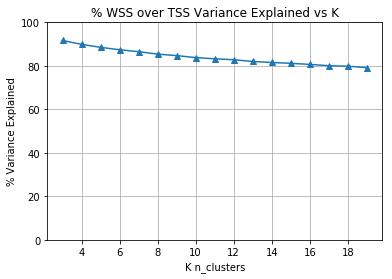

In [80]:
# plot elbow chart wss/tss
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, wcss/tss*100, '^-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('K n_clusters')
plt.ylabel('% Variance Explained')
plt.title('% WSS over TSS Variance Explained vs K')

* Chart 2. Between sum of squares over Total sum of squares

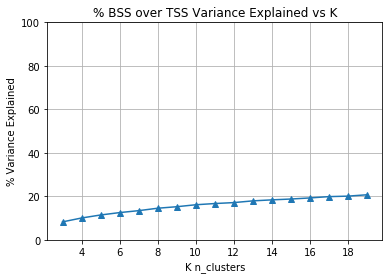

In [81]:
# plot elbow chart bss/tss
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, '^-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('K n_clusters')
plt.ylabel('% Variance Explained')
plt.title('% BSS over TSS Variance Explained vs K')

In [15]:
bss/tss*100

array([  8.28774259,  10.07195278,  11.45516744,  12.55474367,
        13.44645198,  14.56308333,  15.25230072,  16.15836422,
        16.71546635,  17.15141151,  17.9429841 ,  18.40837488,
        18.79351871,  19.29252439,  19.8985848 ,  20.12347189,  20.74906637])

In [73]:
# create 16 clusters
My_k = 16
km = KMeans(n_clusters=My_k, init='k-means++', max_iter=100, random_state = 42)
news_k = km.fit(cv_dm_array)
clusters = km.labels_.tolist()
amazonReview['clusters'] = clusters

In [75]:
print(amazonReview['clusters'].value_counts())
#amazonReview.head()

7     6560
1     1034
2      754
5      479
15     422
6      261
3      199
11     131
0      122
9      108
13     104
12      65
8       13
14       4
4        4
10       1
Name: clusters, dtype: int64


In [49]:
cluster1 = amazonReview[(amazonReview['clusters'] == 0)]
#print(cluster1.index)
cluster2 = amazonReview[(amazonReview['clusters'] == 1)]
cluster3 = amazonReview[(amazonReview['clusters'] == 2)]
cluster4 = amazonReview[(amazonReview['clusters'] == 3)]
cluster5 = amazonReview[(amazonReview['clusters'] == 4)]
cluster6 = amazonReview[(amazonReview['clusters'] == 5)]

In [50]:
cv_dm_array = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
cluster1_cv_dm_array = cv_dm_array[cluster1.index];
print(cluster1_cv_dm_array.shape)
cluster1_count = np.sum(cluster1_cv_dm_array, axis = 0).tolist()
cluster1_count_df = pd.DataFrame(cluster1_count, index = names, columns = ['count'])
cluster1_count_df.sort_values(['count'], ascending = False).head(10)

(110, 690)


,count
amp,693
sound,597
pedal,394
like,313
tone,307
use,297
good,214
just,211
guitar,202
play,188


In [51]:
cv_dm_array = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
cluster2_cv_dm_array = cv_dm_array[cluster2.index];
print(cluster2_cv_dm_array.shape)
cluster2_count = np.sum(cluster2_cv_dm_array, axis = 0).tolist()
cluster2_count_df = pd.DataFrame(cluster2_count, index = names, columns = ['count'])
cluster2_count_df.sort_values(['count'], ascending = False).head(10)

(8035, 690)


,count
great,2696
guitar,2664
use,2642
good,2269
string,2214
work,2063
like,1919
just,1866
sound,1851
buy,1634


In [52]:
cv_dm_array = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
cluster3_cv_dm_array = cv_dm_array[cluster3.index];
print(cluster3_cv_dm_array.shape)
cluster3_count = np.sum(cluster3_cv_dm_array, axis = 0).tolist()
cluster3_count_df = pd.DataFrame(cluster3_count, index = names, columns = ['count'])
cluster3_count_df.sort_values(['count'], ascending = False).head(10)

(235, 690)


,count
string,1778
guitar,632
sound,383
play,326
like,253
use,239
just,216
good,196
set,192
make,190


In [53]:
cv_dm_array = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
cluster4_cv_dm_array = cv_dm_array[cluster4.index];
print(cluster4_cv_dm_array.shape)
cluster4_count = np.sum(cluster4_cv_dm_array, axis = 0).tolist()
cluster4_count_df = pd.DataFrame(cluster4_count, index = names, columns = ['count'])
cluster4_count_df.sort_values(['count'], ascending = False).head(10)

(833, 690)


,count
pedal,1414
sound,1397
use,1250
like,841
just,779
amp,760
great,653
good,633
make,559
pedals,525


In [54]:
cv_dm_array = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
cluster5_cv_dm_array = cv_dm_array[cluster5.index];
print(cluster5_cv_dm_array.shape)
cluster5_count = np.sum(cluster5_cv_dm_array, axis = 0).tolist()
cluster5_count_df = pd.DataFrame(cluster5_count, index = names, columns = ['count'])
cluster5_count_df.sort_values(['count'], ascending = False).head(10)

(266, 690)


,count
pick,1217
play,214
guitar,177
like,173
use,173
just,137
grip,100
string,98
great,96
used,90


In [55]:
cv_dm_array = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
cluster6_cv_dm_array = cv_dm_array[cluster6.index];
print(cluster6_cv_dm_array.shape)
cluster6_count = np.sum(cluster6_cv_dm_array, axis = 0).tolist()
cluster6_count_df = pd.DataFrame(cluster6_count, index = names, columns = ['count'])
cluster6_count_df.sort_values(['count'], ascending = False).head(10)

(782, 690)


,count
guitar,2746
strap,637
use,620
string,550
just,548
like,482
good,426
make,417
play,401
sound,389


#### Q3. Write a short description of the outcome of your clustering exercise. Make sure your answer is no longer than four paragraphs, and should at minimum answer these questions:
*	How many clusters did you “find”? Why did you select that number? 
*	Can you easily describe your clusters with a text label?  If so, what are the labels and how do they help?  If not, why not? 
Audience: general – management or non-technical staff. NOTE: this is a GENERAL AUDIENCE RESPONSE - be VERY careful with how you describe the clustering exercise.  Detailed descriptions of K-means is not required but any discussion of them must be NON TECHNICAL (but not fluffy).   


I selected six clusters.  I tried three to twenty clusters.  The six clusters shows unique/distinct groups, and within each group text key terms are similar to each other (see chart 1 and chart 2 above). 

The details of the six groups are listed below.  There are total of 10,261 reviews in the dataset, and 690 key terms (one or two words terms) retrieved from the text.  The number of items in each group, and the most frequent terms are listed in table 3 below.  

                                         Table 3.  Group numbers and most frequent terms
| Group      | Numbers of reviews |  most frequent Terms     |            
|:----------:|:------------------:|:------------------------:|
| Group 1    | 110                |   amp, sound             |
| Group 2    | 8035               |   great, guitar, use	 |
| Group 3    | 235                |   string, guitar	     |
| Group 4    | 833                |   pedal, sound, use	     |
| Group 5    | 266                |   pick           	     |
| Group 6    | 782                |   guitar, strap, use     |


From this data I can easily describe the six clusters. Group one must is about amps and sounds of the instruments, group two are very general category, group 3 are string and guitars, group 4 are pedals, group 5 are picks, group 6 is strap, guitars.  If I choose a higher number of clusters then group 2 "general category" will further divide into smaller groups, but some of the other groups would not have unique key terms.  Therefore, I ended up six clusters.


END